In [2]:
import pandas as pd

# Title 

## Introduction

## Goal

## Steps
1. Data Cleaning / EDA
2. Modeling / Model Selection
3. Interpretation of Results 

## Results / Conclusions

# Code

## Data Cleaning / EDA

In [2]:
# Importing packages 
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Importing data
player_data = pd.read_csv("player_data.csv")
season_stats = pd.read_csv("Seasons_Stats.csv")

Here, we have two different datasets we can analyze and work with. Let's take a look at the player_data dataset first and explore it. 

In [5]:
# Exploring player_data dataset
player_data.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University


#### Handling Missing Data

In [6]:
# Are there any missing values? 
player_data.isna().sum()

name            0
year_start      0
year_end        0
position        1
height          1
weight          6
birth_date     31
college       302
dtype: int64

We will handle the missing data in a couple ways. For position, height, and weight, it should be easy to impute the data as we can use the existing data to predict the values. For example, we can use group-wise mean imputation as height, weight, and position usually have correlation. Lastly, for colleges and birth_date, this will be more difficult. However, I think we can do probabilistic imputation and draw from the distribution.

In [7]:
# Looking at missing position data
player_data[player_data['position'].isna()]

,name,year_start,year_end,position,height,weight,birth_date,college
2142,George Karl,1974,1978,NaN,NaN,NaN,"May 12, 1952",University of North Carolina


Unfortunately, it turns out that the player has 3 missing values. In this case, I will just remove this row. Thankfully it is just one player. 

In [8]:
# Dropping row
player_data = player_data.drop(player_data.index[[2142]])

In [9]:
# Looking at missing weight data
player_data[player_data['weight'].isna()]

,name,year_start,year_end,position,height,weight,birth_date,college
2360,Dick Lee,1968,1968,F,6-6,NaN,NaN,University of Washington
2783,Murray Mitchell,1950,1950,C,6-6,NaN,"March 19, 1923",Sam Houston State University
2973,Paul Nolen,1954,1954,C,6-10,NaN,"September 3, 1929",Texas Tech University
4279,Ray Wertis,1947,1948,G,5-11,NaN,"January 1, 1922",St. John's University
4472,Bob Wood,1950,1950,G,5-10,NaN,"October 7, 1921",Northern Illinois University


In [10]:
# Group-wise Mean Imputation
player_data.weight = player_data.weight.fillna(player_data.groupby('position')['weight'].transform('mean'))

In [11]:
# Looking at missing college data and birthdate
player_data[player_data['college'].isna()].head()

,name,year_start,year_end,position,height,weight,birth_date,college
9,Alex Abrines,2017,2018,G-F,6-6,190.0,"August 1, 1993",NaN
32,Alexis Ajinca,2009,2017,C,7-2,248.0,"May 6, 1988",NaN
38,Furkan Aldemir,2015,2015,F-C,6-10,240.0,"August 9, 1991",NaN
74,David Andersen,2010,2011,C,6-11,245.0,"June 23, 1980",NaN
100,Martynas Andriuskevicius,2006,2006,C,7-2,240.0,"March 12, 1986",NaN


In [12]:
# Probabilistic Imputation for college
num_null = player_data.college.isnull().sum() # number of nulls
fill_values = player_data.college.dropna().sample(num_null, replace=True)  # draw fill vals from distribution
fill_values.index = player_data.loc[player_data.college.isnull()].index  # align the index, which is missing?
player_data = player_data.fillna({'college': fill_values.to_dict()})  # fill the vals

In [13]:
# Probabilistic Imputation for birth_date
num_null = player_data.birth_date.isnull().sum() # number of nulls
fill_values = player_data.birth_date.dropna().sample(num_null, replace=True)  # draw fill vals from distribution
fill_values.index = player_data.loc[player_data.birth_date.isnull()].index  # align the index, which is missing?
player_data = player_data.fillna({'birth_date': fill_values.to_dict()})  # fill the vals

### A couple questions come to mind from seeing our dataset. 
1. What is the average career length a player has? Does it change over year_start?
2. Which colleges produce the best stat players? 
3. Any change in height and weight as time progresses? 
4. Is there a common birth month with position? 

#### 1. What is the average career length a player has? Does it change over year_start?

In [14]:
player_data['career_length'] = player_data.year_end - player_data.year_start
player_data['career_length'].value_counts().head()

0    1317
1     566
2     394
3     314
4     244
Name: career_length, dtype: int64

What stands out to me is the high frequency of 0 year careers. You would think that most careers would be at least couple years. I want to see what type of players have such a short basketball career.

In [15]:
# Dataset with only players with 0 years in career
player_data[player_data.career_length == 0].head()

,name,year_start,year_end,position,height,weight,birth_date,college,career_length
7,Forest Able,1957,1957,G,6-3,180.0,"July 27, 1932",Western Kentucky University,0
11,Don Ackerman,1954,1954,G,6-0,183.0,"September 4, 1930",Long Island University,0
13,Bud Acton,1968,1968,F,6-6,210.0,"January 11, 1942",Hillsdale College,0
23,Bam Adebayo,2018,2018,C-F,6-10,243.0,"July 18, 1997",University of Kentucky,0
31,Matthew Aitch,1968,1968,F,6-7,230.0,"September 21, 1944",Michigan State University,0


I want to see if their age when they started in the NBA was a factor.

In [16]:
# Extracting Birth year and getting age when they started
birth_year = player_data.birth_date.str.split(",")
temp = birth_year.apply(lambda x: int(x[1]))
player_data['birth_year'] = temp
player_data['age_started'] = player_data['year_start'] - player_data['birth_year']

In [17]:
# Relationship between Age started and Career Length
mean_ages = []
career = []
for i in range(23): 
    mean_ages.append(player_data[player_data.career_length == i].age_started.mean())
    career.append(i)

Text(0, 0.5, 'Career Length (Years)')

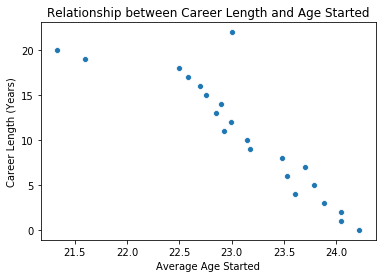

In [18]:
ax = sns.scatterplot(x=mean_ages, y=career)
plt.title('Relationship between Career Length and Age Started')
plt.xlabel('Average Age Started')
plt.ylabel('Career Length (Years)')

According to our data, the younger you start in the NBA, the longer your NBA career will be. This makes sense as players who start when they are younger tend to do so because coaches believe in their ability. This may indicate a long and fruitful career where they are always in demand by teams. However, players who start later in their career will always have the age factor and may not be as desirable by other teams. 

#### 2. Which colleges produce the best stat players?

In order to answer this question, we will use the season_stats dataset we imported in the beginning and merge it with out player_data dataset. 

In [19]:
# Merging Dataframe on 'name'
season_stats = season_stats.rename(columns={"Player": "name"})
merged = pd.merge(player_data, season_stats, on='name')

In [20]:
# Let's see if we can remove some columns
merged.columns

Index(['name', 'year_start', 'year_end', 'position', 'height', 'weight',
       'birth_date', 'college', 'career_length', 'birth_year', 'age_started',
       'Unnamed: 0', 'Year', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [21]:
# Dropping repetitive or irrelevant columns
merged = merged.drop(columns=['Unnamed: 0','blanl','blank2','Pos','birth_date'])

In [22]:
# Looking at missingess
merged.isna().sum()

name                0
year_start          0
year_end            0
position            0
height              0
weight              0
college             0
career_length       0
birth_year          0
age_started         0
Year                0
Age                 8
Tm                  0
G                   0
GS               5482
MP                443
PER               475
TS%                87
3PAr             4918
FTr               101
ORB%             3139
DRB%             3139
TRB%             2460
AST%             1675
STL%             3139
BLK%             3139
TOV%             4234
USG%             4175
OWS                34
DWS                34
WS                 34
WS/48             475
OBPM             3134
DBPM             3134
BPM              3134
VORP             3134
FG                  0
FGA                 0
FG%               101
3P               4829
3PA              4829
3P%              8324
2P                  0
2PA                 0
2P%               134
eFG%      

Looks like there are a lot of missing stats data. We will have to figure out what we should do with them. 

In [23]:
# Looking at GS (Games Started)
(merged.GS == 0).sum()

5268

We will drop players with 0 games played as the missing values in stats would be due to this. If there are no games played, there will be no stats to obtain. 

In [24]:
merged = merged[merged.GS > 0]
merged.isna().sum()

name                0
year_start          0
year_end            0
position            0
height              0
weight              0
college             0
career_length       0
birth_year          0
age_started         0
Year                0
Age                 0
Tm                  0
G                   0
GS                  0
MP                  0
PER                 0
TS%                 0
3PAr                0
FTr                 0
ORB%                0
DRB%                0
TRB%                0
AST%                0
STL%                0
BLK%                0
TOV%                0
USG%                0
OWS                 0
DWS                 0
WS                  0
WS/48               0
OBPM                0
DBPM                0
BPM                 0
VORP                0
FG                  0
FGA                 0
FG%                 0
3P                  0
3PA                 0
3P%              1540
2P                  0
2PA                 0
2P%                 1
eFG%      

Looks like it solved most of our missingness! 

In [27]:
# Looking at 3P% (3 Point Percentage)
merged[merged["3P%"].isna()].iloc[:,39:42].head()

,3P,3PA,3P%
1,0.0,0.0,NaN
4,0.0,0.0,NaN
70,0.0,0.0,NaN
77,0.0,0.0,NaN
97,0.0,0.0,NaN


Missingness of 3p% is dependent on 3p made and 3p attempts. Since these players never made an attempt to shoot, we want to see what positions these players are typically in to conclude whether or not we should remove these players.

In [29]:
merged[merged["3P"] == 0].position.value_counts()

C      1141
F      1033
F-C     846
C-F     439
G       232
F-G      72
G-F      66
Name: position, dtype: int64

Most players seem to be in the Center or Forward position combination. These positions are notable for driving into the paint and not doing many 3 pters (if any). We will keep these rows. 

Our next step is to determine which stats are suitable metrics of comparisons. We will use Player Win Score as our metric. 


**player win score = 
points + rebounds + steals + .5(assists) + .5(blocked shots) - FG attempts - turnovers - .5(FT attempts) - .5(personal fouls)** 

In [40]:
merged.columns

Index(['name', 'year_start', 'year_end', 'position', 'height', 'weight',
       'college', 'career_length', 'birth_year', 'age_started', 'Year', 'Age',
       'Tm', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [43]:
merged["player_win_score"] = (merged.PTS + merged.TRB + merged.STL + .5 * merged.AST + 
        .5 * merged.BLK - merged.FGA - merged.TOV - .5 * merged.FTA - .5 * merged.PF)

In [47]:
merged.groupby("college")["player_win_score"].mean().sort_values(ascending=False).head()

college
Marshall University                 902.500000
Montana State University            899.678571
Illinois Wesleyan University        764.100000
Norfolk State University            617.239130
Trinity Valley Community College    571.285714
Name: player_win_score, dtype: float64